## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statstests.process import stepwise
from utils.data_wrangling import normalize_string, pascal_to_snake, get_formula
from utils.modeling_metrics import vif_tolerance, confusion_matrix, confusion_metrics
from sklearn.metrics import auc, roc_curve

## Loading Files

In [2]:
df_telco = pd.read_csv("datasets/telco-customer-churn.csv")

## Data Wrangling

In [3]:
# Pandas visualization config
pd.set_option("display.max.columns", None)

In [4]:
# Visualize data
df_telco

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [5]:
# Formatting column names to simplify DataFrame handling
df_telco.rename({
    "customerID": "customer_id",
    "StreamingTV": "streaming_tv"
    },
axis=1,
inplace=True
)

df_telco.columns = pascal_to_snake(df_telco.columns)

df_telco.columns

Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents',
       'tenure', 'phone_service', 'multiple_lines', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'churn'],
      dtype='object')

In [7]:
# Fix total_charges data type
df_telco["total_charges"] = pd.to_numeric(df_telco.total_charges, errors='coerce')

# Checking for missing values (NA) in rows
na_count = df_telco.isna().any(axis=1).sum()
print(f"Number of rows with missing values: {na_count}")


Number of rows with missing values: 11


In [8]:
# Droping NA rows
df_telco.dropna(how='any', inplace=True)

# Checking for missing values (NA) in rows
na_count = df_telco.isna().any(axis=1).sum()
print(f"Number of rows with missing values: {na_count}")

Number of rows with missing values: 0


In [9]:
# Inspecting DataFrame structure
df_telco.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7032 non-null   object 
 1   gender             7032 non-null   object 
 2   senior_citizen     7032 non-null   int64  
 3   partner            7032 non-null   object 
 4   dependents         7032 non-null   object 
 5   tenure             7032 non-null   int64  
 6   phone_service      7032 non-null   object 
 7   multiple_lines     7032 non-null   object 
 8   internet_service   7032 non-null   object 
 9   online_security    7032 non-null   object 
 10  online_backup      7032 non-null   object 
 11  device_protection  7032 non-null   object 
 12  tech_support       7032 non-null   object 
 13  streaming_tv       7032 non-null   object 
 14  streaming_movies   7032 non-null   object 
 15  contract           7032 non-null   object 
 16  paperless_billing  7032 non-n

In [98]:
# Summarizing numeric variables
df_telco.describe()

,senior_citizen,tenure,monthly_charges,total_charges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [99]:
# Summarizing non-numeric variables
df_telco.select_dtypes(include=object).describe().T

,count,unique,top,freq
customer_id,7032,7032,3186-AJIEK,1
gender,7032,2,Male,3549
partner,7032,2,No,3639
dependents,7032,2,No,4933
phone_service,7032,2,Yes,6352
multiple_lines,7032,3,No,3385
internet_service,7032,3,Fiber optic,3096
online_security,7032,3,No,3497
online_backup,7032,3,No,3087
device_protection,7032,3,No,3094


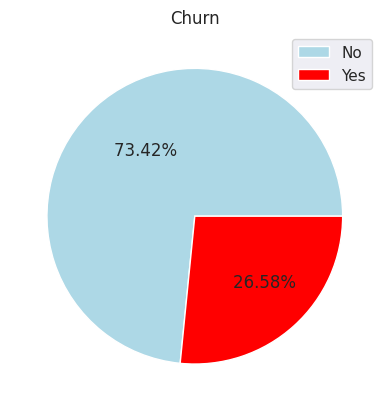

In [107]:
# Visualizing churn percentage
df_churn = df_telco.churn.value_counts()

plt.pie(
    df_churn,
    autopct="%9.2f%%",
    colors={"lightblue":"No", "red":"Yes"},
)

plt.legend(df_churn.index)
plt.title("Churn")
plt.show()

In [12]:
# One-hot encoding
df_telco_dummies = pd.get_dummies(
    data=df_telco.drop("phone_service", axis=1),
    columns = df_telco.drop(["churn", "customer_id", "phone_service"], axis=1).select_dtypes(include=object).columns,
    drop_first=True,
    dtype=int
)

df_telco_dummies["churn"] = np.where(df_telco_dummies.churn == 'Yes', 1, 0)

df_telco_dummies.columns = normalize_string(df_telco_dummies.columns)

# Dropping redundant variables/categories
df_telco_dummies.drop(
    df_telco_dummies.loc[:,df_telco_dummies.columns.str.endswith("_no_internet_service")],
    axis=1,
    inplace=True
)

# Visualize data with dummies
df_telco_dummies

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,churn,gender_male,partner_yes,dependents_yes,multiple_lines_no_phone_service,multiple_lines_yes,internet_service_fiber_optic,internet_service_no,online_security_yes,online_backup_yes,device_protection_yes,tech_support_yes,streaming_tv_yes,streaming_movies_yes,contract_one_year,contract_two_year,paperless_billing_yes,payment_method_credit_card_automatic,payment_method_electronic_check,payment_method_mailed_check
0,7590-VHVEG,0,1,29.85,29.85,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
1,5575-GNVDE,0,34,56.95,1889.50,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1
2,3668-QPYBK,0,2,53.85,108.15,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1
3,7795-CFOCW,0,45,42.30,1840.75,0,1,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0
4,9237-HQITU,0,2,70.70,151.65,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,0,24,84.80,1990.50,0,1,1,1,0,1,0,0,1,0,1,1,1,1,1,0,1,0,0,1
7039,2234-XADUH,0,72,103.20,7362.90,0,0,1,1,0,1,1,0,0,1,1,0,1,1,1,0,1,1,0,0
7040,4801-JZAZL,0,11,29.60,346.45,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
7041,8361-LTMKD,1,4,74.40,306.60,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1


In [13]:
df_telco_dummies

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,churn,gender_male,partner_yes,dependents_yes,multiple_lines_no_phone_service,multiple_lines_yes,internet_service_fiber_optic,internet_service_no,online_security_yes,online_backup_yes,device_protection_yes,tech_support_yes,streaming_tv_yes,streaming_movies_yes,contract_one_year,contract_two_year,paperless_billing_yes,payment_method_credit_card_automatic,payment_method_electronic_check,payment_method_mailed_check
0,7590-VHVEG,0,1,29.85,29.85,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
1,5575-GNVDE,0,34,56.95,1889.50,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1
2,3668-QPYBK,0,2,53.85,108.15,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1
3,7795-CFOCW,0,45,42.30,1840.75,0,1,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0
4,9237-HQITU,0,2,70.70,151.65,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,0,24,84.80,1990.50,0,1,1,1,0,1,0,0,1,0,1,1,1,1,1,0,1,0,0,1
7039,2234-XADUH,0,72,103.20,7362.90,0,0,1,1,0,1,1,0,0,1,1,0,1,1,1,0,1,1,0,0
7040,4801-JZAZL,0,11,29.60,346.45,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
7041,8361-LTMKD,1,4,74.40,306.60,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1


> * Perfect correlation caused by the same or equivalent categories being present in multiple columns can lead to problems during the stepwise procedure.
>
> * The stepwise procedure can handle multicollinearity related to other variables/categories when perfect correlation does not occur.

In [14]:
# Inspecting DataFrame structure after dummies
df_telco_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   customer_id                           7032 non-null   object 
 1   senior_citizen                        7032 non-null   int64  
 2   tenure                                7032 non-null   int64  
 3   monthly_charges                       7032 non-null   float64
 4   total_charges                         7032 non-null   float64
 5   churn                                 7032 non-null   int64  
 6   gender_male                           7032 non-null   int64  
 7   partner_yes                           7032 non-null   int64  
 8   dependents_yes                        7032 non-null   int64  
 9   multiple_lines_no_phone_service       7032 non-null   int64  
 10  multiple_lines_yes                    7032 non-null   int64  
 11  internet_service_fiber

## Diagnosis

In [15]:
# Multicollinearity diagnosis (VIF and Tolerance)
df_vif_tolerance = vif_tolerance(df=df_telco_dummies, endog="churn", drop_columns=["customer_id"])
df_vif_tolerance

,variables,vif,tolerance
0,monthly_charges,866.089640,0.001155
1,internet_service_fiber_optic,148.500814,0.006734
2,internet_service_no,104.213701,0.009596
3,multiple_lines_no_phone_service,34.893857,0.028658
4,streaming_movies_yes,24.156394,0.041397
5,streaming_tv_yes,24.080019,0.041528
6,total_charges,10.811490,0.092494
7,tenure,7.584453,0.131849
8,multiple_lines_yes,7.289761,0.137179
9,device_protection_yes,6.924754,0.144409


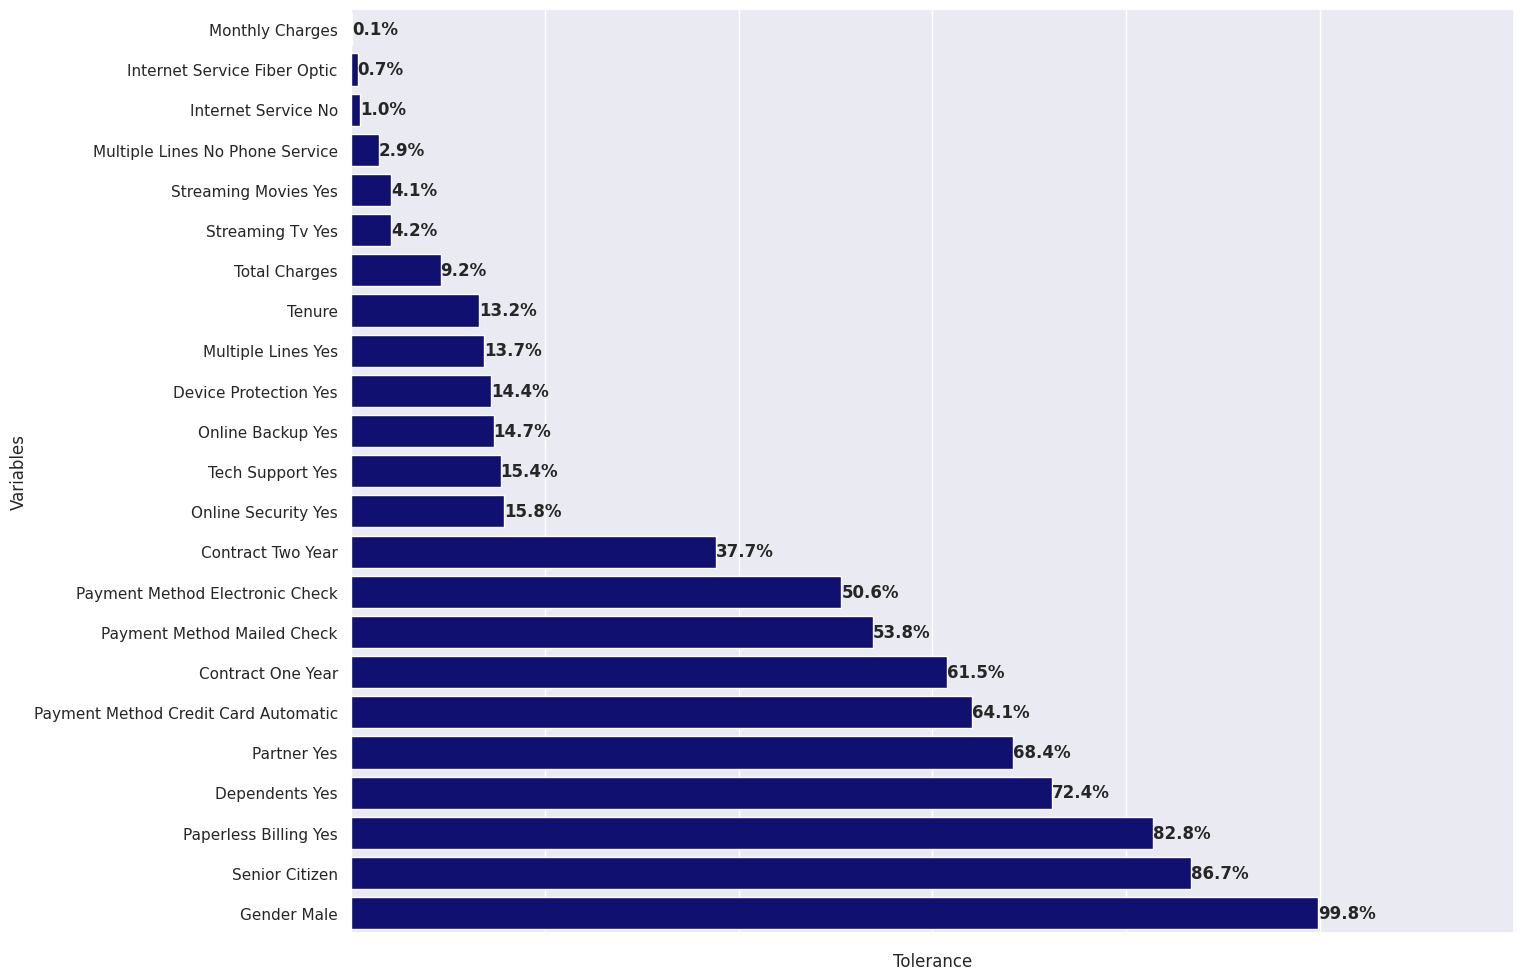

In [16]:
# Multicollinearity diagnosis (VIF and Tolerance)
sns.set_theme(style="darkgrid")
plt.figure(figsize=(15,12))

ax = sns.barplot(
    data=df_vif_tolerance,
    y="variables",
    x="tolerance",
    color="navy",
    orient='h'
)

for i, p in enumerate(ax.patches):
    ax.annotate(
        f"{p.get_width():.1%}",
        xy=(p.get_width(), i),
        fontsize=12,
        va="center",
        ha="left",
        weight="bold")

plt.xlabel("Tolerance")
plt.ylabel("Variables")

plt.xticks(ticks=ax.get_xticks(), labels=[])
plt.yticks(
    ticks=ax.get_yticks(),
    labels=[label.get_text().replace("_", " ").title() for label in ax.get_yticklabels()]
    )

plt.show()

## Binary Logistic Model

In [17]:
# Model Formula
formula = get_formula(df_telco_dummies, endog='churn', drop_columns=["customer_id"])
print(formula)

churn ~ senior_citizen + tenure + monthly_charges + total_charges + gender_male + partner_yes + dependents_yes + multiple_lines_no_phone_service + multiple_lines_yes + internet_service_fiber_optic + internet_service_no + online_security_yes + online_backup_yes + device_protection_yes + tech_support_yes + streaming_tv_yes + streaming_movies_yes + contract_one_year + contract_two_year + paperless_billing_yes + payment_method_credit_card_automatic + payment_method_electronic_check + payment_method_mailed_check


In [18]:
logit_model = smf.logit(data=df_telco_dummies, formula=formula).fit()

Optimization terminated successfully.
         Current function value: 0.414269
         Iterations 8


In [19]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7008
Method:                           MLE   Df Model:                           23
Date:                Sat, 30 Nov 2024   Pseudo R-squ.:                  0.2845
Time:                        04:42:00   Log-Likelihood:                -2913.1
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                1.3368      1.439      0.929      0.353      -1.483       4.156
senior_citizen                           0.2168      0.085      2.564      0.010       0.051       0.382
tenure                                  -0.0606      0.006     -9.716      0.000      -0.073      -0.048
monthly_charges                         -0.0403      0.032     -1.270      0.204      -0.103       0.022
total_charges                            0.0003   7.06e-05      4.657      0.000       0.000       0.000
gender_male                             -0.0218      0.065     -0.337      0.736      -0.149       0.105
partner_yes                             -0.0004      0.078     -0.005      0.996      -0.153       0.152
dependents_yes                          -0.1485      0.090     -1.655      0.098      -0.324       0.027
multiple_lines_no_phone_service         -0.1715      0.649     -0.264      0.792      -1.443       1.100
multiple_lines_yes                       0.4484      0.177      2.530      0.011       0.101       0.796
internet_service_fiber_optic             1.7475      0.798      2.190      0.029       0.183       3.312
internet_service_no                     -1.7863      0.807     -2.213      0.027      -3.369      -0.204
online_security_yes                     -0.2054      0.179     -1.150      0.250      -0.556       0.145
online_backup_yes                        0.0260      0.175      0.148      0.882      -0.318       0.370
device_protection_yes                    0.1474      0.176      0.836      0.403      -0.198       0.493
tech_support_yes                        -0.1805      0.181     -0.999      0.318      -0.534       0.173
streaming_tv_yes                         0.5905      0.326      1.810      0.070      -0.049       1.230
streaming_movies_yes                     0.5993      0.327      1.834      0.067      -0.041       1.240
contract_one_year                       -0.6608      0.108     -6.142      0.000      -0.872      -0.450
contract_two_year                       -1.3571      0.176     -7.691      0.000      -1.703      -1.011
paperless_billing_yes                    0.3424      0.074      4.596      0.000       0.196       0.488
payment_method_credit_card_automatic    -0.0878      0.114     -0.770      0.442      -0.311       0.136
payment_method_electronic_check          0.3045      0.094      3.222      0.001       0.119       0.490
payment_method_mailed_check             -0.0576      0.115     -0.501      0.616      -0.283       0.168
========================================================================================================
"""

In [20]:
logit_model_sw = stepwise(logit_model)

Regression type: Logit 

Estimating model...: 
 churn ~ Q('senior_citizen') + Q('tenure') + Q('monthly_charges') + Q('total_charges') + Q('gender_male') + Q('partner_yes') + Q('dependents_yes') + Q('multiple_lines_no_phone_service') + Q('multiple_lines_yes') + Q('internet_service_fiber_optic') + Q('internet_service_no') + Q('online_security_yes') + Q('online_backup_yes') + Q('device_protection_yes') + Q('tech_support_yes') + Q('streaming_tv_yes') + Q('streaming_movies_yes') + Q('contract_one_year') + Q('contract_two_year') + Q('paperless_billing_yes') + Q('payment_method_credit_card_automatic') + Q('payment_method_electronic_check') + Q('payment_method_mailed_check')
Optimization terminated successfully.
         Current function value: 0.414269
         Iterations 8

 Discarding atribute "Q('partner_yes')" with p-value equal to 0.9960634460836288 

Estimating model...: 
 churn ~ Q('senior_citizen') + Q('tenure') + Q('monthly_charges') + Q('total_charges') + Q('gender_male') + Q('depen

In [21]:
logit_model_sw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                 7032
Model:                          Logit   Df Residuals:                     7016
Method:                           MLE   Df Model:                           15
Date:                Sat, 30 Nov 2024   Pseudo R-squ.:                  0.2838
Time:                        04:42:00   Log-Likelihood:                -2916.1
converged:                       True   LL-Null:                       -4071.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.8040      0.265      3.037      0.002       0.285       1.323
Q('senior_citizen')                      0.2437      0.083      2.941      0.003       0.081       0.406
Q('tenure')                             -0.0610      0.006     -9.950      0.000      -0.073      -0.049
Q('monthly_charges')                    -0.0302      0.006     -5.223      0.000      -0.042      -0.019
Q('total_charges')                       0.0003      7e-05      4.787      0.000       0.000       0.000
Q('multiple_lines_yes')                  0.3930      0.088      4.490      0.000       0.221       0.565
Q('internet_service_fiber_optic')        1.4916      0.192      7.768      0.000       1.115       1.868
Q('internet_service_no')                -1.5618      0.177     -8.810      0.000      -1.909      -1.214
Q('online_security_yes')                -0.2622      0.090     -2.927      0.003      -0.438      -0.087
Q('tech_support_yes')                   -0.2293      0.091     -2.513      0.012      -0.408      -0.050
Q('streaming_tv_yes')                    0.4973      0.098      5.094      0.000       0.306       0.689
Q('streaming_movies_yes')                0.5112      0.096      5.298      0.000       0.322       0.700
Q('contract_one_year')                  -0.6638      0.107     -6.198      0.000      -0.874      -0.454
Q('contract_two_year')                  -1.3600      0.176     -7.738      0.000      -1.704      -1.016
Q('paperless_billing_yes')               0.3440      0.074      4.632      0.000       0.198       0.490
Q('payment_method_electronic_check')     0.3528      0.069      5.098      0.000       0.217       0.488
========================================================================================================
"""

In [ ]:
# calculating churn probability
df_telco_dummies[["customer_id", "churn"]].assign(
    prob=logit_model_sw.predict()
).sort_values("prob", ascending=False)

,customer_id,churn,prob
1976,9497-QCMMS,1,0.856110
4800,9300-AGZNL,1,0.854447
3749,4424-TKOPW,1,0.851685
1410,7024-OHCCK,1,0.850585
6368,2720-WGKHP,1,0.850472
...,...,...,...
5018,6928-ONTRW,0,0.001302
1527,0640-YJTPY,0,0.001301
1824,0794-YVSGE,0,0.001288
932,5787-KXGIY,0,0.001285


## Model Metrics

{'Accuracy': 0.8053185437997725,
 'Sensitivity': 0.5537720706260032,
 'Specificity': 0.8963780747627348}

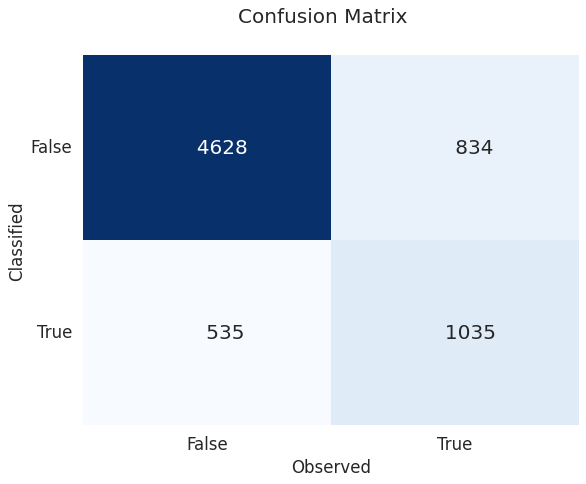

In [23]:
confusion_matrix(logit_model_sw, cutoff=0.5)

In [24]:
df_metrics = confusion_metrics(logit_model_sw)
df_metrics

,cutoff,accuracy,sensitivity,specificity
0,0.01,0.360922,0.996255,0.130932
1,0.02,0.425341,0.991439,0.220414
2,0.03,0.461746,0.986089,0.271935
3,0.04,0.493174,0.983414,0.315708
4,0.05,0.520620,0.976458,0.355607
...,...,...,...,...
95,0.96,0.734215,0.000000,1.000000
96,0.97,0.734215,0.000000,1.000000
97,0.98,0.734215,0.000000,1.000000
98,0.99,0.734215,0.000000,1.000000


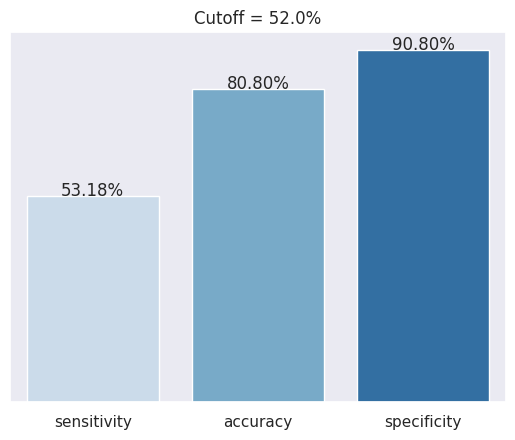

In [108]:
# Cutoff that maximizes the accuracy
def max_accuracy(df: pd.DataFrame) -> None:

    df_info = df.loc[df_metrics['accuracy'].idxmax()].sort_values()

    cutoff = df_info.cutoff

    info_dict = df_info.drop("cutoff").to_dict()

    ax = sns.barplot(
        x = info_dict.keys(),
        y = info_dict.values(),
        hue = info_dict.keys(),
        palette="Blues"
    )

    for i, p in enumerate(ax.patches):
        plt.annotate(f"{p.get_height():.2%}", xy=(i, p.get_height()), ha="center")

    plt.yticks([])
    plt.ylabel(None)
    plt.title(f"Cutoff = {cutoff:.1%}")

max_accuracy(df_metrics)

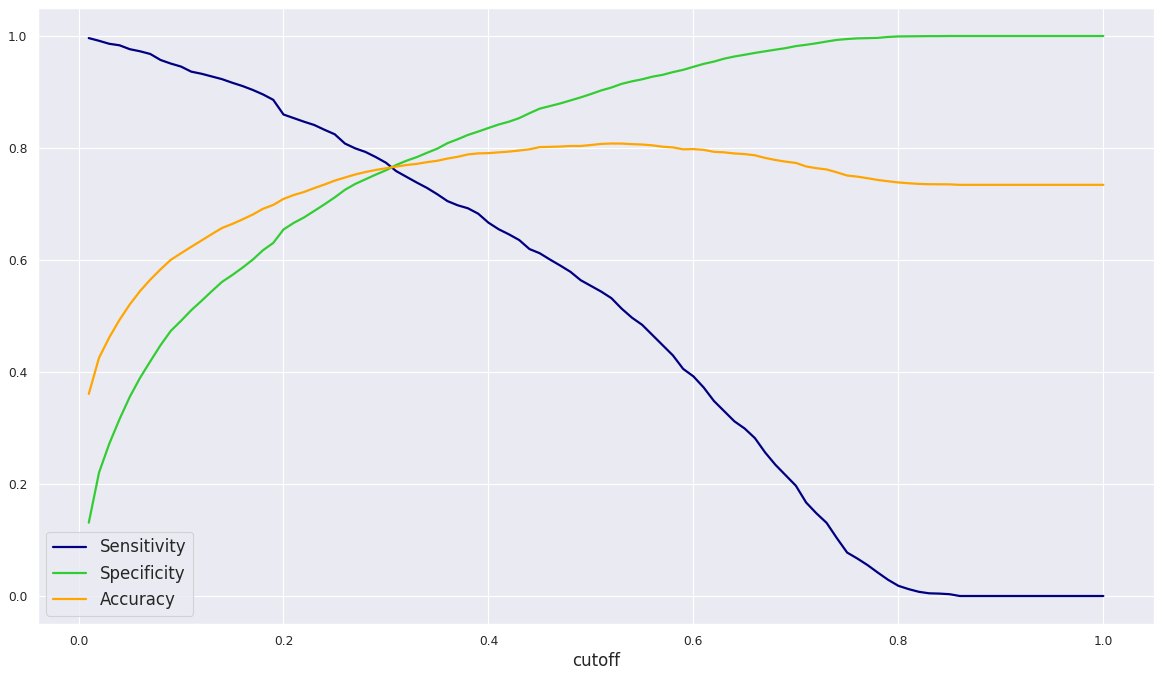

In [26]:
plt.figure(figsize=(18,10), dpi=80)

plt.plot(
    df_metrics.cutoff,
    df_metrics.sensitivity,
    color="navy",
    lw=2,
    label="Sensitivity"
)

plt.plot(
    df_metrics.cutoff,
    df_metrics.specificity,
    color='limegreen',
    lw=2,
    label="Specificity"
)

plt.plot(
    df_metrics.cutoff,
    df_metrics.accuracy,
    color="orange",
    lw=2,
    label="Accuracy"
)

plt.xlabel("cutoff", fontsize=15)

plt.legend(fontsize=15)
plt.show()

In [27]:
fpr, tpr, thresholds = roc_curve(
    y_true=logit_model_sw.model.endog,
    y_score=logit_model_sw.predict()
)

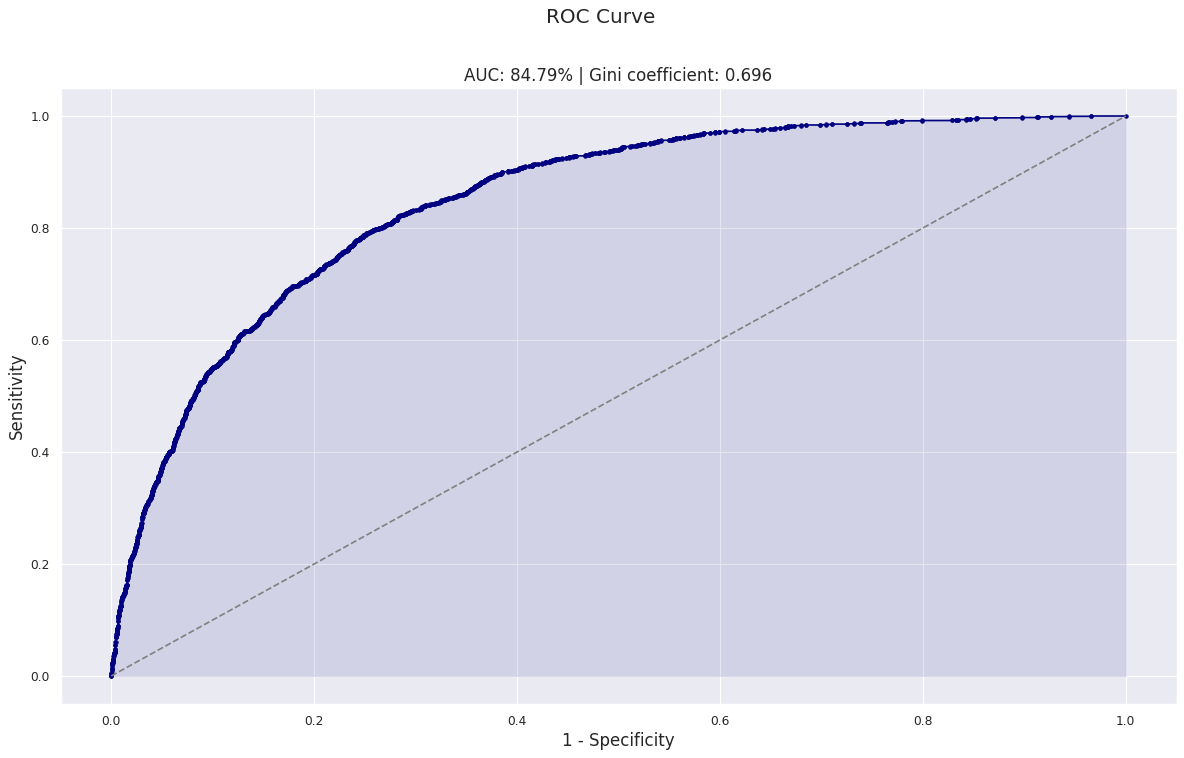

In [28]:
roc_auc = auc(x=fpr, y=tpr)
gini = (roc_auc - 0.5) / 0.5

plt.figure(figsize=(18,10), dpi=80)

plt.plot(
    fpr,
    tpr,
    color="navy",
    marker="."
)

plt.fill_between(
    fpr,
    tpr,
    color="navy",
    alpha=0.1
)

plt.plot(
    [0,1],
    [0,1],
    ls = "--",
    color="grey"
)

plt.xlabel("1 - Specificity", fontsize=15)
plt.ylabel("Sensitivity", fontsize=15)

plt.title(f"AUC: {roc_auc:.2%} | Gini coefficient: {gini:.3f}", fontsize=15)
plt.suptitle("ROC Curve", fontsize=18)

plt.show()